<a href="https://colab.research.google.com/github/NoviantoAryansyah/ML_HOMEWORK/blob/main/FinalExam(UAS)/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CIFAR-10: MLP, CNN, ResNet9 Classifier**

Import libraries

In [3]:
import time

import pandas as pd
import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 

import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Constants
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
COLOR_CHANNELS = 3
N_CLASSES = 10

In [5]:
# check if cuda is available
cuda = torch.cuda.is_available()
print(cuda)

False


**Load raw CIFAR-10 Dataset and Labels**

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
train_dataset = CIFAR10(root='.',
                        train=True,
                        transform=transform,
                        download=True)

test_dataset  = CIFAR10(root='.',
                        train=False,
                        transform=transform,)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


In [8]:
# check the meta data and batch labels
data_batch_1 = pd.read_pickle(r'./cifar-10-batches-py/data_batch_1')
meta_data    = pd.read_pickle(r'./cifar-10-batches-py/batches.meta')

In [9]:
print(data_batch_1.keys())
print(meta_data.keys())

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
dict_keys(['num_cases_per_batch', 'label_names', 'num_vis'])


In [10]:
one_hot_labels = set(data_batch_1['labels']) # One-hot encoding labels
one_hot_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [11]:
labels_name = meta_data['label_names']
labels_name

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [12]:
label_dict = {k:v for k,v in zip(one_hot_labels, labels_name)} # dict(zip(labels, one_hot))
label_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [13]:
label_dict.get(8)

'ship'

In [14]:
# check the shape of the dataset 
train_data = list(train_dataset)
test_data  = list(test_dataset)
print(f'Train data shape: {len(train_data)}')
print(f'Test data shape:  {len(test_data)}')

Train data shape: 50000
Test data shape:  10000


In [15]:
# check the shape of an image in the train data
image, label = train_data[300]
print(image.shape)
print(label)

torch.Size([3, 32, 32])
2


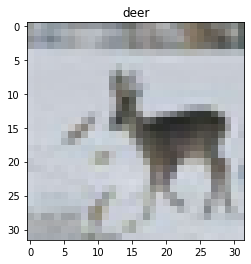

In [16]:
# check some random training images 
def imshow(img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # tensor.permute = np.transpose
    plt.title(''.join(f'{label_dict.get(label)}' )) # show label
    

# plt.imshow(image.permute(1,2,0))
# plt.show()

# get some random training images
image, label = train_data[20]

imshow(image, label)

plt.show()

**Create DataLoader**

In [17]:
batch_size = 64         # hyper-parameter 
train_loader = torch.utils.data.DataLoader(
                            dataset = train_dataset, 
                            batch_size = batch_size, 
                            shuffle = True)

test_loader = torch.utils.data.DataLoader(
                            dataset = test_dataset, 
                            batch_size = batch_size, 
                            shuffle = True)

In [18]:
# check the shape of the batches 
dd = list(train_loader)

In [19]:
images, labels = dd[0]
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


**Defining the Networks**

In this section, will build three neural network models:

Multi-Layer Perceptron (MLP)
Convolutional Neural Network (CNN)
ResNet9

**MLP**

In [20]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, n_hidden_units, n_classes):
    super(MLP, self).__init__()

    h1, h2, h3 = n_hidden_units

    # Add Linear layers
    self.fc1 = nn.Linear(input_size,h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, n_classes) # 10 classes
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = x.view(-1, input_size) # Flatten out the input layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.fc4(x)
    return x

In [21]:
# Initialize MLP model
input_size = IMAGE_HEIGHT*IMAGE_WIDTH*COLOR_CHANNELS
n_hidden_units = [512, 256, 128]

mlp_model = MLP(input_size, n_hidden_units, N_CLASSES)

In [22]:
# check the shape of MLP model
output = mlp_model(images)
output.shape

torch.Size([64, 10])

**CNN**

In [23]:
def conv3x3(in_channels, out_channels, stride=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

In [24]:
class CNN(torch.nn.Module):
  def __init__(self, in_channels, n_classes):
    super(CNN, self).__init__()
    # Conv layers
    self.conv =conv3x3(in_channels=in_channels, out_channels=64)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)

    #self.conv0 =conv3x3(in_channels=in_channels, out_channels=64)
    #self.bn0 = nn.BatchNorm2d(64)

    # Residual block
    self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU(inplace=True)

    # Pooling
    self.avg_pool = nn.AvgPool2d(2)

    # Linear layers
    self.fc1 = nn.Linear(16384, 64 )
    self.fc2 = nn.Linear(64, n_classes)

  def forward(self, x):
    
    #print(identity.shape)
    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)

    #out = self.conv0(x)
    #out = self.bn0(out)
    #out = self.relu(out)

    out = self.conv1(out)
    out = self.bn1(out)
    out = self.relu1(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu2(out)  # skip connection + out
    #print(out.shape)

    out = self.avg_pool(out)

    out = out.view(out.size(0), -1) # Flatten all dimension except batch
    #print(out.shape)

    out = self.fc1(out)
    out = F.relu(out)

    out = self.fc2(out)
    #out = F.log_softmax(out, dim=-1) # if using cross entropy, dont need to use log softmax since it's already implemented in cross entropy

    return out

In [25]:
cnn_model = CNN(in_channels=3, n_classes=10)

In [26]:
images, labels = dd[0]
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [27]:
# Check the output shape of the model
output = cnn_model(images)
output.shape

torch.Size([64, 10])

**ResNet9**

In [28]:
class BasicResidualBlock(nn.Module):
  def __init__(self):
    super(BasicResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out)
    return self.relu2(out) + identity # ReLU can be applied before or after adding the identity/input

In [29]:
# Checking the output size of the BasicResidualBlock
simple_resblock = BasicResidualBlock()
images, labels = dd[0]
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [30]:
out = simple_resblock(images)
out.shape

torch.Size([64, 3, 32, 32])

In [31]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: 
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [32]:
class ResNet9(nn.Module):
  def __init__(self, in_channels, n_classes):
    super(ResNet9, self).__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1  = nn.Sequential(conv_block(128,128), conv_block(128,128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2  = nn.Sequential(conv_block(512,512), conv_block(512,512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(512, 128),
                                    nn.Linear(128, n_classes))
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out # skip connection
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out # skip connection
    out = self.classifier(out)
    return out

In [33]:
resnet_model = ResNet9(3,10)
resnet_model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [34]:
images, labels = dd[0]
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [35]:
out = resnet_model(images)
out.shape

torch.Size([64, 10])

Helper functions

In [36]:
def prediction(data_loader, model, criterion, cuda=None):
  correct = 0
  total = 0
  losses = 0

  for i, (images, labels) in enumerate(data_loader):
    if cuda is not None:
      # switch tensor type to GPU
      images = images.cuda()
      labels = labels.cuda()
    
    # Flatten the images
    #images = images.view(-1, input_size)
    
    outputs = model(images)
    
    loss = criterion(outputs, labels)
  
    _, predictions = torch.max(outputs, dim=1)
  
    correct += torch.sum(labels == predictions).item()
    total += labels.shape[0]
    
    losses += loss.data.item()
    
  return losses/len(list(data_loader)), 1 - correct/total # we need to normalize loss with respect to the number of batches 

**Define a Loss function and optimizer**

Learning rate scheduling: Learning rate scheduler -> change the learning rate after every batch of training. "One Cycle Learning Rate Policy" -> starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% epochs, then gradually decreasing it to a very low value for the remaining epochs.


Weight decay: Regularization technique to prevent the weights from becoming too large by adding an additional term to the loss function
.

Gradient clipping: it's helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values

Fit one cycle

In [37]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

In [41]:
# define a fit_one_cycle function to incorporate learning rate scheduling, weight decay and gradient clipping
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, criterion,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, cuda=None):
  torch.cuda.empty_cache() # release all unoccupied cached memory
  history = []

  # Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))
  
  if cuda is not None:
    model.cuda() # send model to device

  train_losses = []
  test_losses = []

  train_error_rates = []
  test_error_rates = []

  # Loop through all epochs
  for epoch in range(epochs):
    train_loss = 0
    n_iter = 0
    total = 0
    correct = 0
    lrs = []

    # Training phase
    for i, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad() # zero gradients out before computing others

      if cuda is not None:
        images = images.cuda()
        labels = labels.cuda()

      #images = images.view(-1, input_size) # Flatten input image
      # dont need in this case since it's CNN model
      outputs = model(images) 

      # compute the train_error rates
      # torch.max(input, dim) ->
      # returns the maximum value of all elements in the input tensor
      _, predictions = torch.max(outputs, 1) 
      correct += torch.sum(labels == predictions).item()
      total += labels.shape[0]

      # compute loss
      loss = criterion(outputs, labels)
      # compute gradients
      loss.backward()

      # Gradient clipping:
      if grad_clip is not None:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      # update weights/parameters
      optimizer.step()

      # record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

      train_loss += loss.detach().item()

      n_iter += 1
    
    train_error_rate = 1 - correct/total

    # Validation phase
    with torch.no_grad():
      test_loss, test_error_rate = prediction(val_loader, model, criterion, cuda)

    train_error_rates.append(train_error_rate)
    test_error_rates.append(test_error_rate)
    train_losses.append(train_loss/n_iter)
    test_losses.append(test_loss)
    results ={'train_loss': train_loss/n_iter,'val_loss': test_loss, 'val_acc': (1-train_error_rate)*100}
    results['lrs'] = lrs
    history.append(results)

    if epoch%1 == 0:
      print('Epoch: {}/{}, last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.1f}%'.format(epoch+1, epochs, results['lrs'][-1], train_loss/n_iter, test_loss, (1-train_error_rate)*100))

  return history